In [ ]:
#importing all necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential,Input,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [2]:
!pip install opencv-python

In [6]:
#import os

def load_images_from_folder(foldername):
    images = []
    for filename in os.listdir(foldername):
        img = cv2.imread(os.path.join(foldername,filename))
        if img is not None:
            images.append(img)
    return images
img_list=load_images_from_folder("C:\\Users\\Akhila\\Downloads\\Au")

In [10]:
len(img_list[0])

256

In [3]:
data_dir = r'C:\Users\Akhila\Downloads\Au'
train_dir = os.path.join(data_dir)


In [4]:
#class labels
image_type = ['Authenticated','Tampered']

Performing Error level Analysis

In [5]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

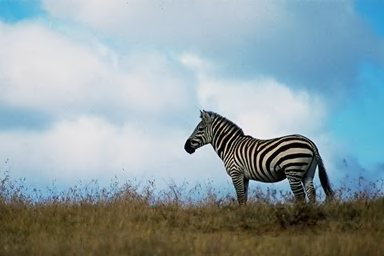

In [6]:
real_image_path = "C:\\Users\\Akhila\\Downloads\\Au\\Au_ani_00001.jpg"
Image.open(real_image_path)

ELA converted image

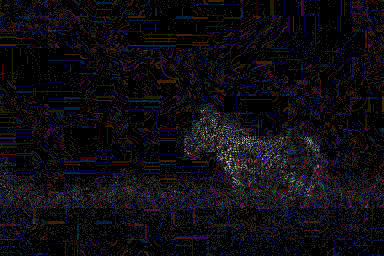

In [7]:
convert_to_ela_image(real_image_path, 85)

Resizing image and converting it for making suitable to model

In [8]:
image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 85).resize(image_size)).flatten() / 255.0

In [9]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

Getting authenticated images

In [10]:
import random
count = 0
path = 'C:\\Users\\Akhila\\Downloads\\Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
#         count+=1
#         if count < 1000:
#             pass
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)  
        if len(Y) % 2000 == 0:
            print(f'Processing {len(Y)} images')
            break
    if len(Y) % 2000 == 0:
        break

random.shuffle(X)
# X = X[:2100]
# Y = Y[:2100]
print(len(X), len(Y))

Processing 2000 images
2000 2000


In [11]:
x_t, y_t = [], []

Getting tampered images

In [12]:
path = 'C:\\Users\\Akhila\\Downloads\\Tp'
count = 0
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
#         count += 1
#         if count < 1000:
#             pass
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
        if len(Y) % 4000 == 0:
            print(f'Processing {len(Y)} images')
            break
    if len(Y) % 4000 == 0:
        break

print(len(X), len(Y))

Processing 4000 images
4000 4000


In [13]:
au,tp=0,0
for i in Y:
    if(i==1):
        au+=1
    else:
        tp+=1
print(tp,au)

2000 2000


In [14]:
from keras.utils.np_utils import to_categorical

In [15]:
#shuffling of images
from sklearn.utils import shuffle
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

In [16]:
#reshaping the image array
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [17]:
#splitting the dataset into training and testing
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=42)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3200 3200
800 800


CUSTOM CNN MODEL

In [17]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

model1 = build_model()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

IMPLEMENTED CUSTOM CNN MODEL

In [18]:
def build_model():
    model = Sequential()
    model.add(Conv2D(input_shape=(128,128,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(units=512,activation="relu"))
    model.add(Dense(units=256,activation="relu"))
    model.add(Dense(units=2, activation="softmax")) 

    print(model.summary())
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                    

In [19]:
from tensorflow.keras.optimizers import Adam

In [20]:
#optimizer for training weights 
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr, decay = init_lr/50)

In [21]:
#compiling the model
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
model1.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
#training the model
batch_size = 32 
epochs = 10

history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    
    batch_size = batch_size,
    validation_data=(X_val, Y_val),
    verbose=2)

# score = model.evaluate(x_test, y_test)
# print('Test accuracy:', score[1])

Epoch 1/10
100/100 - 1146s - loss: 0.4679 - accuracy: 0.7566 - val_loss: 0.3232 - val_accuracy: 0.8800 - 1146s/epoch - 11s/step
Epoch 2/10
100/100 - 2200s - loss: 0.3534 - accuracy: 0.8572 - val_loss: 0.3561 - val_accuracy: 0.8500 - 2200s/epoch - 22s/step
Epoch 3/10
100/100 - 1453s - loss: 0.3446 - accuracy: 0.8616 - val_loss: 0.3330 - val_accuracy: 0.8700 - 1453s/epoch - 15s/step
Epoch 4/10
100/100 - 773s - loss: 0.3158 - accuracy: 0.8666 - val_loss: 0.2979 - val_accuracy: 0.8900 - 773s/epoch - 8s/step
Epoch 5/10
100/100 - 773s - loss: 0.2998 - accuracy: 0.8750 - val_loss: 0.2927 - val_accuracy: 0.8813 - 773s/epoch - 8s/step
Epoch 6/10
100/100 - 780s - loss: 0.3053 - accuracy: 0.8734 - val_loss: 0.2858 - val_accuracy: 0.8900 - 780s/epoch - 8s/step
Epoch 7/10
100/100 - 2506s - loss: 0.2697 - accuracy: 0.8913 - val_loss: 0.2903 - val_accuracy: 0.8725 - 2506s/epoch - 25s/step
Epoch 8/10
100/100 - 1131s - loss: 0.2645 - accuracy: 0.8894 - val_loss: 0.3073 - val_accuracy: 0.8737 - 1131s/ep

In [ ]:
for layer in model.layers:
    weights = layer.get_weights()
    print(weights)

In [23]:
#saving the trained model
model.save("model.h5")

VALIDATION ACCURACY ACHIEVED FOR 10 EPOCHS -  0.885
